<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/Solar_P2H2P_gaisifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pymoo used for optimization
from IPython.display import clear_output
!pip install pymoo
clear_output()

In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

In [6]:
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA.csv')
# df = df[0:500]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [7]:
df.describe()

,Unnamed: 0,ghi,air_temperature,deficit_energy
count,183960.000000,183960.000000,183960.000000,1.839600e+05
mean,91979.500000,0.218271,11.596737,2.363687e+05
std,53104.822097,0.311458,8.223487,1.422785e+06
min,0.000000,0.000000,-8.630000,-4.837150e+06
25%,45989.750000,0.000000,4.888750,-7.083003e+05
50%,91979.500000,0.005384,12.802500,7.045418e+05
75%,137969.250000,0.403645,17.676667,1.265331e+06
max,183959.000000,1.147850,29.931667,2.438273e+06


In [8]:
'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

In [9]:
'''
    Calculating the Annualized system cost(ASC) and the levelised cost of energy(LCOE)
'''
def cost_electrolyser(electrolyser, electrolyser_elec):
  electrolyser_cap = ((585.85+(9458.2/electrolyser)*electrolyser**0.622)*((2024/2020)**(-158.9)))
  electrolyser_elec_op = electrolyser_elec*0.04*CRF
  electrolyser_op = 0.04*CRF*electrolyser_cap + electrolyser_elec_op
  electrolyser_cost = CRF*electrolyser_cap+electrolyser_op
  return electrolyser_cost

def cost_tank(tank):
  tank_cap = tank*350
  tank_op = tank_cap*CRF*0.01
  tank_cost = CRF*tank_cap + tank_op
  return tank_cost

def cost_fuelcell(fuellcell):
  fuellcell_cap = fuellcell*1600
  fuellcell_op = fuellcell_cap*CRF*0.04
  fuellcell_cost = CRF*fuellcell_cap + fuellcell_op
  return fuellcell_cost

def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  # print(solar_cost)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  # print(gasifier_cost)
  return gasifier_cost

def LCOE(total_energy_prod, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_electrolyser(electrolyser, electrolyser_elec)+cost_tank(tank)+cost_fuelcell(fuelcell)
  energy_prod_per_year = total_energy_prod/N
  lcoe = ASC/(energy_prod_per_year)
  return ASC, lcoe

def LCOH(total_hydrogen_prod, solar, electrolyser_elec, electrolyser, tank, fuelcell):
  ASC = cost_pv(solar)+cost_electrolyser(electrolyser, electrolyser_elec)+cost_tank(tank)+cost_fuelcell(fuelcell)
  hydrogen_prod_per_year = total_hydrogen_prod/N
  lcoh = ASC/(hydrogen_prod_per_year)
  return lcoh

In [10]:
'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

In [11]:
'''
Calculation required for P2H2P.
'''
def fuel_cell_energy(fuellcell, hydrogen_lev):
  'maximum energy produced by fuelcell'
  rated_hr_energy = fuellcell
  rated_h2_consumption = rated_hr_energy/(33.33*0.4)
  if rated_h2_consumption>hydrogen_lev:
    energy_output = rated_hr_energy*(hydrogen_lev/rated_h2_consumption)
  else:
    energy_output = rated_hr_energy

  return energy_output

def electrolyser_hydrogen(electrolyser, energy):
  h2_prod_rated = electrolyser*0.7/39.4
  h2_made = 0
  if energy >= electrolyser:
      h2_made = h2_prod_rated
  else:
      h2_made = (energy/electrolyser)*h2_prod_rated
  return h2_made

def fuel_cell_h2_used(energy, fuellcell):
  rated_h2_consumed = fuellcell/(33.33*0.4)
  if energy==fuellcell:
    h2_consumed = rated_h2_consumed
  else:
    h2_consumed = (energy*rated_h2_consumed)/fuellcell
  return h2_consumed

In [12]:
'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, tank_lev, tank_max, electrolyser, fuelcell,  solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  tank_lev_up = tank_lev
  fuelcell_supply = 0
  hydrogen_excess = 0
  electrolyser_ene = 0


  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)
  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run fuelcell and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and fuelcell
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if tank_lev>0:
        if req_energy<=(fuel_cell_energy(fuelcell, tank_lev)):
          '''
          req_energy met by only fuelcell
          '''
          fuelcell_supply = req_energy
          energy_served+=fuelcell_supply
          tank_lev_up = tank_lev-fuel_cell_h2_used(req_energy, fuelcell)

        else:
          '''
          req_energy met by fuelcell and gasifier
          '''
          gasifier_E_req = req_energy-(fuel_cell_energy(fuelcell, tank_lev))
          fuelcell_supply = fuel_cell_energy(fuelcell, tank_lev)
          energy_served+=fuelcell_supply
          tank_lev_up = tank_lev-fuel_cell_h2_used(fuelcell_supply, fuelcell)
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")
    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used in electrolyser for hydrogen production.
      '''
      energy_served+=energy_def  # solar panel served the entire deficit energy
      Ech_t = solar_energy-energy_def  # extra energy from solar used for electrolyser
      h2_made = electrolyser_hydrogen(electrolyser, Ech_t)

      if h2_made<=tank_max-tank_lev:
        tank_lev_up = tank_lev+h2_made

      else:
        tank_lev_up = tank_max
        hydrogen_excess = h2_made - (tank_max-tank_lev)

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy #solar energy already calculated outside loop
    surplus_ene = abs(energy_def)#make hydrogen from this

    Ech_t = 0
    if solar_energy>=electrolyser:
      Ech_t = solar_energy
    else:
      if surplus_ene+solar_energy<electrolyser:
        Ech_t = surplus_ene+solar_energy
        electrolyser_ene = surplus_ene
      else:
        Ech_t = electrolyser
        electrolyser_ene = electrolyser-solar_energy

    h2_made = electrolyser_hydrogen(electrolyser, Ech_t)

    if h2_made<=tank_max-tank_lev:
      tank_lev_up = tank_lev+h2_made

    else:
      tank_lev_up = tank_max
      hydrogen_excess = h2_made - (tank_max-tank_lev)

  return energy_served, fuelcell_supply, tank_lev_up, electrolyser_ene, solar_energy, gasifier_energy, hydrogen_excess

In [17]:
'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      solar, gasifier, electrolyser, tank, fuelcell = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      tank_lev = 0
      electrolyser_elec = 0
      hydrogen_tot = 0

      for i in range(len(df)):
        Energy_served ,fuelcell_supply, tank_lev, electrolyser_ene, solar_ene, gasifier_ene, hydrogen_sold = Energy_prod_(energy_def=df['deficit_energy'][i] , tank_lev=tank_lev ,tank_max=tank, electrolyser=electrolyser, fuelcell=fuelcell, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        electrolyser_elec+=electrolyser_ene
        hydrogen_tot+=hydrogen_sold
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1

      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=5, n_obj=1, n_eq_constr=1, xl=[54061102,  8794909, 540611*6, 0, 10000], xu=[54062102,  8794911, 540621*6, 10, 15000])

In [24]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
algorithm = GA(pop_size=1,
               sampling=IntegerRandomSampling(),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 2)

In [25]:
%%time
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   seed=42,
                   save_history=True)

CPU times: user 14.8 s, sys: 27.1 ms, total: 14.8 s
Wall time: 14.9 s


In [26]:
'''
Optimized results for SOO.
'''
solar, gasifier, electrolyser, tank, fuelcell = results.X
print(f"Solar:{solar}KW, Gasifier: {gasifier}KW, Electrolyser: {electrolyser}KW, Tank: {tank}Kg, Fuelcell: {fuelcell} || LCOE: {results.F}USD/KWh")

Solar:54061204.0KW, Gasifier: 8794909.0KW, Electrolyser: 3243673.6845688904KW, Tank: 10.0Kg, Fuelcell: 13772.0 || LCOE: [1.24099612]USD/KWh


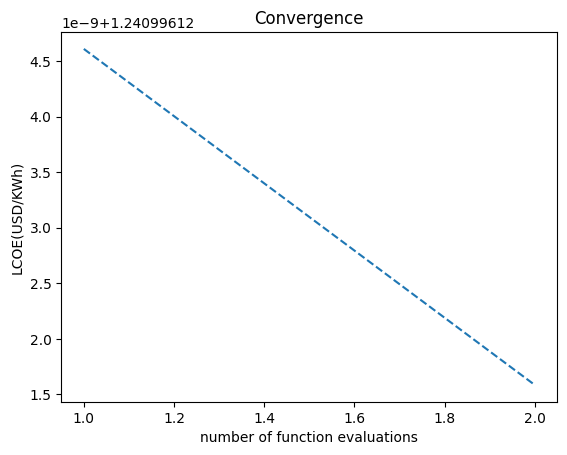

In [27]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.xlabel("number of function evaluations")
plt.ylabel("LCOE(USD/KWh)")
plt.show()

In [32]:
solar, gasifier, electrolyser, tank, fuelcell  = results.X

solar_array = []
gasifier_array = []
fuelcell_array = []
tank_array = []
deficit_array = []

total_supply = []


count = 0
Energy_prod_N = 0 #total energy throughout the project life produced
tank_lev = 0
electrolyser_elec = 0
hydrogen_tot = 0

for i in range(len(df)):
  Energy_served ,fuelcell_supply, tank_lev, electrolyser_ene, solar_ene, gasifier_ene, hydrogen_sold = Energy_prod_(energy_def=df['deficit_energy'][i] , tank_lev=tank_lev ,tank_max=tank, electrolyser=electrolyser, fuelcell=fuelcell, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  electrolyser_elec+=electrolyser_ene
  hydrogen_tot+=hydrogen_sold
  Energy_prod_N += Energy_served
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  fuelcell_array.append(fuelcell_supply)
  tank_array.append(tank_lev)
  total_supply.append(fuelcell_supply+gasifier_ene+solar_ene)

asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, electrolyser_elec, electrolyser, tank, fuelcell)
lcoh = LCOH(hydrogen_tot, solar, electrolyser_elec, electrolyser, tank, fuelcell)
print(asc, lcoe, lcoh)

5683240943.896146 1.2409961215849163 13.24748820615692


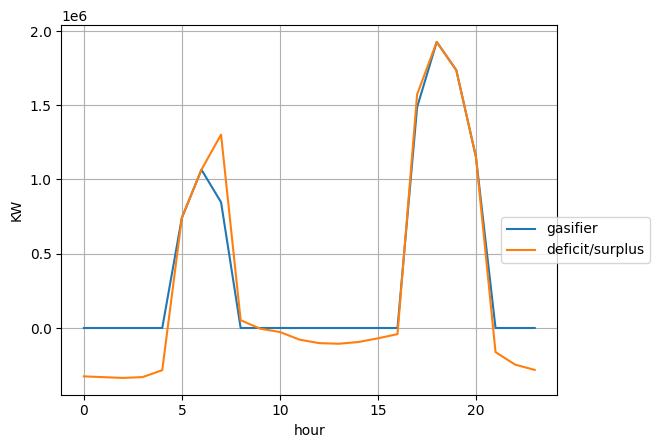

In [36]:
i = 0
j = 24
x = np.arange(i,j)
# plt.plot(x,solar_array[i:j], label='solar')
plt.plot(x,gasifier_array[i:j], label='gasifier')
# plt.plot(x,fuelcell_array[i:j], label = 'fuelcellsupply')
# plt.plot(x,tank_array[i:j], label = 'tank')
# plt.plot(x,np.add(np.array(battery_array[i:j]),-973117), label = 'battery')
plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit/surplus')
# plt.plot(x,np.array(deficit_array[i:j]), label = 'surplus')

plt.xlabel("hour")
plt.ylabel("KW")
# plt.plot(x,total_supply[i:j], label = 'total')
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))